In [100]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams['figure.figsize'] = [16,10]
%config IPCompleter.greedy=True

## RANS solver for fully developed turbulent channel with variable thermophysical properties
 
             Created on: Dec, 2018
                Authors: Rene Pecnik (R.Pecnik@tudelft.nl)
                         Gustavo J. Otero R. (G.J.OteroRodriguez@tudelft.nl)
                         Process & Energy Department, Faculty of 3mE
                         Delft University of Technology, the Netherlands.

       Last modified on: Dec, 2018
                     by: Rene Pecnik 
                     
The detailed derivation and implementation, including the compressiblity corrections for several turbulence models, is outlined in the corresponding publication: 
 * __[Otero et al., 2017. Heat and fluid flow](https://www.sciencedirect.com/science/article/pii/S0142727X18301978)__, 
 * __[link to preprint](http://dutw1479.wbmt.tudelft.nl/~renep/content/papers/2018OteroEtAl_prePrint.pdf)__

## Momentum equation (fully developed channel)
The streamwise momentum equation of the Reynolds-averaged Navier-Stokes equations for a fully developed turbulent channel flow reads, 

$$ \frac{d}{dy}\left[\left(\mu+\mu_t \right) \frac{du}{dy}\right] = -1,$$ 

with $u$ the streamwise velocity, $\mu$ the dynamic visocity, and $\mu_t$ the Eddy viscosity which is obtained by a solving a turbulence model. Wall units are used to non-dimensionalize the Navier-Stokes equations, hence $-1$ defines the forcing on the right-hand-side. 
Using the product rule, the momentum equation can also be written as 
$$ \left[\frac{d\mu_{eff}}{dy}\frac{d}{dy} + \mu_{eff}\frac{d^2}{dy^2}\right] u = -1, $$ 

with $\mu_{eff} = \mu+\mu_t$. Now it is easy to formulate a linear system $ A u = -1 $ which can be solved using a direct linear solver. 

In [101]:
def solveRANS(r_DNS,mu_DNS):

    n    = mesh.nPoints
    u    = np.zeros(n)          # velocity 
    T    = np.ones(n)           # temperature 
    mut  = np.zeros(n)          # eddy viscosity 
    
    r    = r_DNS.copy()
    mu   = mu_DNS.copy()
    
    k    = 0.01*np.ones(n)      # turbulent kinetic energy
    e    = 0.001*np.ones(n)     # turbulent dissipation 
    v2   = 1/3*k                # wall normal turbulent fluctuations for V2F model
    om   = np.ones(n)           # specific turbulent dissipation for omega in SST
    nuSA = np.ones(n)/ReTau     # eddy viscisty for SA model
    
    residual   = 1.0e20
    iterations = 0
    
    print("Start iterating")

    while residual > 1.0e-6 and iterations < 10000:

        # Solve temperature:  d/dy[(lam+mut/PrT)dTdy] = -VolQ/ReTau/Pr
        if solveTemperatureEq == 1:       
            r, mu, T   = solveTemperature(T,r,mu,mut)

        # Solve turbulence model to calculate eddy viscosity 
        if   turbulenceModel == "Cess":   mut        = Cess(r,mu,ReTau,mesh,compressibleCorrection)
        elif turbulenceModel == "SA":     mut,nuSA   = SA(u,nuSA,r,mu,mesh,compressibleCorrection)
        elif turbulenceModel == "MK":     mut,k,e    = MK(u,k,e,r,mu,ReTau,mesh,compressibleCorrection)
        elif turbulenceModel == "SST":    mut,k,om   = SST(u,k,om,r,mu,mesh,compressibleCorrection)
        elif turbulenceModel == "V2F":    mut,k,e,v2 = V2F(u,k,e,v2,r,mu,mesh,compressibleCorrection)
        else:                             mut        = np.zeros(n)

        # Solve momentum equation:  0 = d/dy[(mu+mut)dudy] - 1
        # diffusion matrix: mueff*d2phi/dy2 + dmueff/dy dphi/dy    
        A = np.einsum('i,ij->ij', mesh.ddy@(mu + mut), mesh.ddy) \
          + np.einsum('i,ij->ij', mu + mut, mesh.d2dy2)

        # Solve 
        u_old = u.copy()
        u[1:n-1] = np.linalg.solve(A[1:n-1, 1:n-1], -np.ones(n-2))
        residual = np.linalg.norm(u-u_old)/n

        # Printing residuals
        if iterations%100 == 0: print("iteration: ",iterations, ", Residual(u) = ", residual)
        iterations = iterations + 1

    print("iteration: ",iterations, ", Residual(u) = ", residual)
    
    return u, T, r, mu, mut, k, e, om

## Temperature equation

The temperature equation (normalized by the wall temperature) for a fully developed channel reads

$$\frac{d}{dy}\left[\left(\lambda+\frac{\mu_t}{Pr_t}\right)\frac{dT}{dy}\right] = -\frac{Q}{Re_\tau Pr}, $$ 

with $\lambda$ the thermal conductivity, $Pr_t$ the turbulent Prandtl number, $Q$ the volumetric heat source, and $Re_\tau$ and $Pr$ the reference Reynolds and Prandtl numbers, respectively. The boundary conditions for the normalized temperature at both walls is 1. Using the temperature, the density $\rho$, dynamic viscosity $\mu$ and thermal conductivity $\lambda$ are then calculated as follows, 
* thermal conductivity: $$\lambda = \frac{T^\mathrm{expLam}}{Re_\tau Pr},$$
* density:  $$\rho = T^\mathrm{expRho},$$
* viscosity: $$\mu = \frac{T^\mathrm{expMu}}{Re_\tau}.$$

The exponents determine the relation of these quantities with temperature. If the purpose is to compare the RANS solution with results from DNS, then the exponents, the reference Reynolds and Prandtl numbers, and the volumetric heat source can be found in the DNS data files in line 39.

In [102]:
def solveTemperature(T,r,mu,mut):
    
    n = mesh.nPoints
    
    # molecular thermal conductivity: 
    lam = np.power(T, expLam)/(ReTau*Pr)   
    
    # turbulent Prandtl: assume = 1
    Prt = np.ones(n)                          

    # diffusion matrix: lamEff*d2phi/dy2 + dlamEff/dy dphi/dy
    A = np.einsum('i,ij->ij', mesh.ddy@(lam + mut/Prt), mesh.ddy) \
      + np.einsum('i,ij->ij', lam + mut/Prt, mesh.d2dy2)

    # Isothermal BC
    T[0] = T[-1] = 1              
    
    # source term
    b = -Qvol*np.ones(n-2)/(ReTau*Pr)

    # Solve
    T = solveEqn(T,A,b,0.95)

    # calculate density and viscosity from temperature
    r  = np.power(T, expRho)
    mu = np.power(T, expMu)/ReTau
    
    return r, mu, T

## Implemented turbulence models

There are currently five turbulence models available. 


### 1. 'Cess': 
The first one is an algebraic model, based on the publication 'Cess, R.D., "A survery of the literature on heat transfer in turbulent tube flow", Tech. Rep. 8-0529-R24, Westinghouse, 1958'.
> $$\frac{\mu_t}{\mu} = \frac{1}{2}\left(1+\frac{1}{9}\kappa^2 \color{red}{Re_\tau}^2 \left(2y-y^2\right)^2 \left(3-4y+2y^2\right)^2 \left[1-exp\left(-\frac{\color{red}{y^+}}{A}\right)\right]^2 \right)^{1/2} - \frac{1}{2}$$

To account for varying properties, it is necessary to replace 
$$Re_\tau = \frac{\rho_w u_\tau H}{\mu_w}$$ 
and 
$$y^+ = y*Re_\tau,$$ 
which are indicated in red above, with their semi-locally scaled counterparts $$Re^\star_\tau = Re_\tau = \frac{\bar\rho u_\star H}{\bar\mu}$$
and 
$$y^\star = y*Re_\tau^\star.$$ 
The bar indicates Reynolds averaging. The friction velocities are $u_\tau = \sqrt{\frac{\tau_w}{\rho_w}}$ and $u_\star = \sqrt{\frac{\tau_w}{\bar\rho}}$, respectively, with $\tau_w =\left. \mu_w\frac{du}{dy}\right|_w$.

In [103]:
def Cess(r,mu,ReTau,mesh,compressibleCorrection):

    d = np.minimum(mesh.y, mesh.y[-1]-mesh.y) 

    # Model constants
    kappa   = 0.426
    A       = 25.4

    if compressibleCorrection == 1:
        ReTauArr = np.sqrt(r/r[0])/(mu/mu[0])*ReTau
        yplus = d*ReTauArr
    else: 
        ReTauArr = np.ones(mesh.nPoints)*ReTau
        yplus = d*ReTauArr
        
    df  = 1 - np.exp(-yplus/A)
    t1  = np.power(2*d-d*d, 2)
    t2  = np.power(3-4*d+2*d*d, 2)
    mut = 0.5*np.power(1 + 1/9*np.power(kappa*ReTauArr, 2)*(t1*t2)*df*df, 0.5) - 0.5
    
    return mut*mu

### 2. 'SA': 
Spalart, A. and Allmaras, S., "One equation turbulence model for aerodynamic flows", Recherche Aerospatiale-French edition, 1994.
> Turbulent scalar equation $\tilde \nu$: $$0 = c_{b1} \hat S \tilde\nu - c_{w1} f_w \left(\frac{\tilde\nu}{y}\right)^2 + \frac{1}{\color{red}{\rho}c_{b3}} \frac{d}{dy}\left[\color{red}{\rho}\left(\nu+\tilde\nu\right) \frac{d \tilde\nu}{dy} + \color{red}{\left(\nu+\tilde\nu\right) \frac{\tilde\nu}{2}\frac{d \rho}{dy}}\right] + \frac{c_{b2}}{\color{red}{\rho}c_{b3}} \left(\frac{d \color{red}{\sqrt{\rho}}\tilde\nu}{dy}\right)^2 $$
with the eddy viscosity $$ \mu_t = \rho \tilde\nu f_{v1}$$

The changes for the compressiblity correction are indicated in red. 

In [104]:
def SA(u,nuSA,r,mu,mesh,compressibleCorrection):
    
    n = mesh.nPoints

    # Model constants
    cv1_3   = np.power(7.1, 3.0)
    cb1     = 0.1355
    cb2     = 0.622
    cb3     = 2.0/3.0
    inv_cb3 = 1.0/cb3
    kappa_2 = np.power(0.41, 2.0)
    cw1     = cb1/kappa_2 + (1.0+cb2)/cb3
    cw2     = 0.3
    cw3_6   = np.power(2.0, 6.0)
    
    # Model functions
    strMag        = np.absolute(mesh.ddy@u)      # VortRate = StrainRate in fully developed channel
    wallDist      = np.minimum(mesh.y, mesh.y[-1]-mesh.y) 
    wallDist      = np.maximum(wallDist, 1.0e-8)
    inv_wallDist2 = 1/np.power(wallDist, 2)

    chi           = nuSA*r/mu
    fv1           = np.power(chi, 3)/(np.power(chi, 3) + cv1_3)
    fv2           = 1.0 - (chi/(1.0+(chi*fv1)))
    inv_kappa2_d2 = inv_wallDist2*(1.0/kappa_2)
    Shat          = strMag + inv_kappa2_d2*fv2*nuSA
    inv_Shat      = 1.0/Shat
    r_SA          = np.minimum(nuSA*inv_kappa2_d2*inv_Shat, 10.0)
    g             = r_SA + cw2*(np.power(r_SA, 6) - r_SA)
    g_6           = np.power(g, 6)
    fw_           = np.power(((1.0 + cw3_6)/(g_6+ cw3_6)), (1/6))
    fw            = g*fw_

    # Eddy viscosity
    mut       = np.zeros(n)
    mut[1:-1] = fv1[1:-1]* nuSA[1:-1]*r[1:-1]
    mut[1:-1] = np.minimum(np.maximum(mut[1:-1], 0.0), 100.0)
    
    if compressibleCorrection == 1:  
        nueff = (mu/r + nuSA)*r
        fs    = np.sqrt(r)
        fd    = 1/r
        drdy  = mesh.ddy@r
        Di    = nueff*nuSA*drdy
        drho  = 0.5*inv_cb3/r*(mesh.ddy@Di)
    else:
        nueff = (mu/r + nuSA)
        fs    = np.ones(n)
        fd    = np.ones(n)
        drho  = np.zeros(n)

    # ---------------------------------------------------------------------
    # nuSA-equation 
    
    # diffusion matrix: mueff*d2()/dy2 + dmueff/dy d()/dy
    A = np.einsum('i,ij->ij', nueff*fd, mesh.d2dy2) \
      + np.einsum('i,ij->ij', (mesh.ddy@nueff)*fd, mesh.ddy)
    A = inv_cb3*A
    
    # implicitly treated source term
    np.fill_diagonal(A, A.diagonal() - cw1*fw*nuSA*inv_wallDist2)

    # Right hand side
    dnudy = mesh.ddy@(fs*nuSA)
    b  = - cb1*Shat[1:-1]*nuSA[1:-1] - cb2*inv_cb3*np.power(dnudy[1:-1], 2) - drho[1:-1]
    
    # Wall boundary conditions
    nuSA[0] = nuSA[-1] = 0.0

    # Solve
    nuSA = solveEqn(nuSA, A, b, 0.75)
    nuSA[1:-1] = np.maximum(nuSA[1:-1], 1.e-12)

    return mut,nuSA

### 3. 'MK': 
Myong, H.K. and Kasagi, N., "A new approach to the improvement of k-epsilon turbulence models for wall bounded shear flow", JSME, 1990.
> Turbulent kinetic energy $k$:  $$ 0 = P_k - \rho \varepsilon + \color{red}{\frac{1}{\sqrt\rho}}\frac{d}{dy}\left[\color{red}{\frac{1}{\sqrt\rho}}\left(\mu+\mu_t/\sigma_k\right) \frac{d \color{red}{\rho}k}{dy}\right] $$
 Turbulent dissipation $\varepsilon$: $$ 0 = \frac{\varepsilon}{k}\left(C_{\varepsilon 1} f_1 P_k - C_{\varepsilon 2} f_2 \varepsilon\right) + \color{red}{\frac{1}{\rho}}\frac{d}{dy}\left[\color{red}{\frac{1}{\sqrt\rho}}\left(\mu+\mu_t/\sigma_\varepsilon\right)\frac{d \color{red}{\rho^{3/2}}\varepsilon}{dy}\right] $$
 with the eddy viscosity $$ \mu_t = C_\mu f_\mu \rho \frac{k^2}{\varepsilon}$$
 
 The changes for the compressiblity correction are indicated in red. 

In [105]:
def MK(u,k,e,r,mu,ReTau,mesh,compressibleCorrection):

    n = mesh.nPoints
    d = np.minimum(mesh.y, mesh.y[-1]-mesh.y) 
    
    if compressibleCorrection == 1:
        yplus = d*np.sqrt(r/r[0])/(mu/mu[0])*ReTau
    else: 
        yplus = d*ReTau
    
    # Model constants
    cmu  = 0.09 
    sigk = 1.4 
    sige = 1.3 
    Ce1  = 1.4 
    Ce2  = 1.8
    
    # Model functions 
    ReTurb  = r*np.power(k, 2)/(mu*e)
    f2      = (1-2/9*np.exp(-np.power(ReTurb/6, 2)))*np.power(1-np.exp(-yplus/5), 2)
    fmue    = (1-np.exp(-yplus/70))*(1.0+3.45/np.power(ReTurb, 0.5))
    fmue[0] = fmue[-1] = 0.0
    
    # eddy viscosity
    mut  = cmu*fmue*r/e*np.power(k,2)
    mut[1:-1] = np.minimum(np.maximum(mut[1:-1],1.0e-10),100.0)

    # Turbulent production: Pk = mut*dudy^2
    Pk = mut*np.power(mesh.ddy@u, 2)
    
    # ---------------------------------------------------------------------
    # e-equation
    
    # effective viscosity
    if compressibleCorrection == 1:
        mueff = (mu + mut/sige)/np.sqrt(r)
        fs = np.power(r, 1.5)
        fd = 1/r
    else:
        mueff = mu + mut/sige
        fs = fd = np.ones(n)

    # diffusion matrix: mueff*d2()/dy2 + dmueff/dy d()/dy
    A = np.einsum('i,ij->ij',  mueff*fd, mesh.d2dy2) \
      + np.einsum('i,ij->ij', (mesh.ddy@mueff)*fd, mesh.ddy)

    # Left-hand-side, implicitly treated source term
    np.fill_diagonal(A, A.diagonal() - Ce2*f2*r*e/k/fs)

    # Right-hand-side
    b = -e[1:-1]/k[1:-1]*Ce1*Pk[1:-1]
    
    # Wall boundary conditions
    e[0 ] = mu[ 0]/r[ 0]*k[ 1]/np.power(d[ 1], 2)
    e[-1] = mu[-1]/r[-1]*k[-2]/np.power(d[-2], 2)

    # Solve eps equation
    e = solveEqn(e*fs, A, b, 0.8)/fs
    e[1:-1] = np.maximum(e[1:-1], 1.e-12)
    

    # ---------------------------------------------------------------------
    # k-equation

    # effective viscosity
    if compressibleCorrection == 1:
        mueff = (mu + mut/sigk)/np.sqrt(r)
        fs = r
        fd = 1/np.sqrt(r)
    else:
        mueff = mu + mut/sigk
        fs = fd = np.ones(n)

    # diffusion matrix: mueff*d2()/dy2 + dmueff/dy d()/dy
    A = np.einsum('i,ij->ij',  mueff*fd, mesh.d2dy2) \
      + np.einsum('i,ij->ij', (mesh.ddy@mueff)*fd, mesh.ddy)
    
    # implicitly treated source term
    np.fill_diagonal(A, A.diagonal() - r*e/k/fs)
    
    # Right-hand-side
    b  = -Pk[1:-1]
    
    # Wall boundary conditions
    k[0] = k[-1] = 0.0
    
    # Solve TKE
    k = solveEqn(k*fs, A, b, 0.7)/fs
    k[1:-1] = np.maximum(k[1:-1], 1.e-12)

    return mut,k,e

### 4. 'SST': 
Menter, F.R., "Zonal Two equation k-omega turbulence models for aerodynamic flows", AIAA 93-2906, 1993.
> Turbulent kinetic energy $k$: $$0 = P_k - \beta^\star \rho k \omega + \color{red}{\frac{1}{\sqrt\rho}}\frac{d}{dy}\left[\color{red}{\frac{1}{\sqrt\rho}}\left(\mu+\mu_t/ \sigma_k\right) \frac{d \color{red}{\rho}k}{dy}\right]$$  
  Specific turbulent dissipation $\omega$: $$ 0 = \rho\frac{\alpha P_k}{\mu_t} - \beta \rho \omega^2 + \frac{d}{dy}\left[\color{red}{\frac{1}{\sqrt\rho}}\left(\mu+\mu_t \sigma_\omega\right) \frac{d \color{red}{\sqrt\rho}\omega}{dy}\right] + \left(1-F_1\right) CD_{k\omega}$$
 with the eddy viscosity: $$\mu_t = \rho k ~\mathrm{min} \left(\frac{1}{\omega}, \frac{a_1}{\|S\| F_2} \right)$$
 
The changes for the compressiblity correction are indicated in red. 

In [106]:
def SST(u,k,om,r,mu,mesh,compressibleCorrection):

    n = mesh.nPoints

    # model constants
    sigma_k1  = 0.85
    sigma_k2  = 1.0
    sigma_om1 = 0.5
    sigma_om2 = 0.856
    beta_1    = 0.075
    beta_2    = 0.0828
    betaStar  = 0.09
    a1        = 0.31
    alfa_1    = beta_1/betaStar - sigma_om1*0.41**2.0/betaStar**0.5
    alfa_2    = beta_2/betaStar - sigma_om2*0.41**2.0/betaStar**0.5    
    
    # Relaxation factors
    underrelaxK  = 0.6
    underrelaxOm = 0.4
        
    # required gradients
    dkdy  = mesh.ddy@k
    domdy = mesh.ddy@om
    
    wallDist = np.minimum(mesh.y, mesh.y[-1]-mesh.y) 
    wallDist = np.maximum(wallDist, 1.0e-8)


    # VortRate = StrainRate in fully developed channel
    strMag = np.absolute(mesh.ddy@u) 
    
    # Blending functions 
    CDkom  = 2.0*sigma_om2*r/om*dkdy*domdy
    gamma1 = 500.0*mu/(r*om*wallDist*wallDist)
    gamma2 = 4.0*sigma_om2*r*k/(wallDist*wallDist*np.maximum(CDkom,1.0e-20))
    gamma3 = np.sqrt(k)/(betaStar*om*wallDist)
    gamma  = np.minimum(np.maximum(gamma1, gamma3), gamma2)
    bF1    = np.tanh(np.power(gamma, 4.0))
    gamma  = np.maximum(2.0*gamma3, gamma1)
    bF2    = np.tanh(np.power(gamma, 2.0))

    # more model constants
    alfa     = alfa_1*bF1    + (1-bF1)*alfa_2
    beta     = beta_1*bF1    + (1-bF1)*beta_2
    sigma_k  = sigma_k1*bF1  + (1-bF1)*sigma_k2
    sigma_om = sigma_om1*bF1 + (1-bF1)*sigma_om2
    
    # Eddy viscosity
    zeta = np.minimum(1.0/om, a1/(strMag*bF2))
    mut = r*k*zeta
    mut = np.minimum(np.maximum(mut,0.0),100.0)
    
    # ---------------------------------------------------------------------
    # om-equation
    
    # effective viscosity
    if compressibleCorrection == 1:
        mueff = (mu + sigma_om*mut)/np.sqrt(r)
        fs    = np.sqrt(r)
    else:
        mueff = mu + sigma_om*mut
        fs    = np.ones(n)

    # diffusion matrix: mueff*d2()/dy2 + dmueff/dy d()/dy
    A = np.einsum('i,ij->ij', mueff, mesh.d2dy2) \
      + np.einsum('i,ij->ij', mesh.ddy@mueff, mesh.ddy)
    
    # implicitly treated source term
    np.fill_diagonal(A, A.diagonal() - beta*r*om/fs)

    # Right-hand-side
    b = -alfa[1:-1]*r[1:-1]*strMag[1:-1]*strMag[1:-1] - (1-bF1[1:-1])*CDkom[1:-1]
    
    # Wall boundary conditions
    om[0 ] = 60.0*mu[0 ]/beta_1/r[0 ]/wallDist[1 ]/wallDist[1 ]
    om[-1] = 60.0*mu[-1]/beta_1/r[-1]/wallDist[-2]/wallDist[-2]

    # Solve
    om = solveEqn(om*fs, A, b, underrelaxOm)/fs
    om[1:-1] = np.maximum(om[1:-1], 1.e-12)
    
    # ---------------------------------------------------------------------
    # k-equation    
    
    # effective viscosity
    if compressibleCorrection == 1:
        mueff = (mu + sigma_k*mut)/np.sqrt(r)
        fs    = r
        fd    = np.sqrt(r)
    else:
        mueff = mu + sigma_k*mut
        fs    = np.ones(n)
        fd    = np.ones(n)

    # diffusion matrix: mueff*d2()/dy2 + dmueff/dy d()/dy
    A = np.einsum('i,ij->ij', mueff*fd, mesh.d2dy2) \
      + np.einsum('i,ij->ij', (mesh.ddy@mueff)*fd, mesh.ddy)

    # implicitly treated source term
    np.fill_diagonal(A, A.diagonal() - betaStar*r*om/fs)

    # Right-hand-side
    Pk = np.minimum(mut*strMag*strMag, 20*betaStar*k*r*om)
    b  = -Pk[1:-1]
    
    # Wall boundary conditions
    k[0] = k[-1] = 0.0
    
    # Solve
    k = solveEqn(k*fs, A, b, underrelaxK)/fs
    k[1:-1] = np.maximum(k[1:-1], 1.e-12)

    return mut,k,om

### 5. 'V2F':
Medic, G. and Durbin, P.A., "Towards improved prediction of heat transfer on turbine blades", ASME, J. Turbomach. 2012. 
> Turbulent kinetic energy $k$:  $$0 = P_k - \rho \varepsilon + \color{red}{\frac{1}{\sqrt\rho}}\frac{d}{dy}\left[\color{red}{\frac{1}{\sqrt\rho}}\left(\mu+\mu_t/\sigma_k\right) \frac{d \color{red}{\rho}k}{dy}\right]$$
  Turbulent dissipation $\varepsilon$:  $$0 = \frac{1}{T}\left(C_{\varepsilon1} P_k - C_{\varepsilon2} \rho \varepsilon\right)  + \color{red}{\frac{1}{\rho}}\frac{d}{dy}\left[\color{red}{\frac{1}{\sqrt\rho}}\left(\mu+\mu_t/\sigma_\varepsilon\right)\frac{d\color{red}{\rho^{3/2}}\varepsilon}{dy}\right]$$
  'Wall-normal' fluctuation component $v'^2$: $$0 = \rho k f - 6 \rho v'^2 \frac{\varepsilon}{k} + \color{red}{\frac{1}{\sqrt\rho}}\frac{d}{dy}\left[\color{red}{\frac{1}{\sqrt\rho}}\left(\mu+\mu_t/\sigma_k\right) \frac{d\color{red}{\rho} v'^2}{dy}\right]$$
  Ellitic relaxation equation $f$:  $$L^2 \frac{d^2f}{dy^2} - f = \frac{1}{T}\left[C1 -6\frac{v'^2}{k} -\frac{2}{3}\left(C_1-1\right)\right] - \frac{C_2 P_k}{\rho k}$$
 with the eddy viscosity: $$\mu_t = C_\mu \rho v'^2 T_t$$
 
 The changes for the compressiblity correction are indicated in red. 

In [107]:
def V2F(u,k,e,v2,r,mu,mesh,compressibleCorrection):
    
    n = mesh.nPoints
    f = np.zeros(n)

    # Model constants
    cmu  = 0.22 
    sigk = 1.0 
    sige = 1.3 
    Ce2  = 1.9
    Ct   = 6 
    Cl   = 0.23 
    Ceta = 70 
    C1   = 1.4 
    C2   = 0.3

    # Relaxation factors
    underrelaxK  = 0.8
    underrelaxE  = 0.8
    underrelaxV2 = 0.8

    # Time and length scales, eddy viscosity and turbulent production
    Tt  = np.maximum(k/e, Ct*np.power(mu/(r*e), 0.5))
    Lt  = Cl*np.maximum(np.power(k, 1.5)/e, Ceta*np.power(np.power(mu/r, 3)/e, 0.25))
    mut = np.maximum(cmu*r*v2*Tt, 0.0)
    Pk  = mut*np.power(mesh.ddy@u, 2.0)


    # ---------------------------------------------------------------------
    # f-equation 
    
    # implicitly treated source term
    A = np.einsum('i,ij->ij',Lt*Lt, mesh.d2dy2)
    np.fill_diagonal(A, A.diagonal() - 1.0)
    
    # Right-hand-side
    vok  = v2[1:-1]/k[1:-1]
    rhsf = ((C1-6)*vok - 2/3*(C1-1))/Tt[1:-1] - C2*Pk[1:-1]/(r[1:-1]*k[1:-1])
    
    # Solve
    f = solveEqn(f,A,rhsf,1)
    f[1:-1] = np.maximum(f[1:-1], 1.e-12)

    
    # ---------------------------------------------------------------------
    # v2-equation: 
    
    # effective viscosity and pre-factors for compressibility implementation
    if compressibleCorrection == 1:
        mueff = (mu + mut)/np.sqrt(r)
        fs    = r
        fd    = 1/np.sqrt(r)
    else:
        mueff = mu + mut
        fs    = np.ones(n)
        fd    = np.ones(n)

    # diffusion matrix: mueff*d2()/dy2 + dmueff/dy d()/dy
    A = np.einsum('i,ij->ij', mueff*fd, mesh.d2dy2) \
      + np.einsum('i,ij->ij', (mesh.ddy@mueff)*fd, mesh.ddy)

    # implicitly treated source term
    np.fill_diagonal(A, A.diagonal() - 6.0*r*e/k/fs)
    
    # Right-hand-side
    b = -r[1:-1]*k[1:-1]*f[1:-1]
    
    # Wall boundary conditions
    v2[0] = v2[-1] = 0.0
    
    # Solve
    v2 = solveEqn(v2*fs,A,b,underrelaxV2)/fs
    v2[1:-1] = np.maximum(v2[1:-1], 1.e-12)
    

    # ---------------------------------------------------------------------
    # e-equation
        
    # effective viscosity
    if compressibleCorrection == 1:
        mueff = (mu + mut/sige)/np.sqrt(r)
        fs    = np.power(r, 1.5)
        fd    = 1/r
    else:
        mueff = mu + mut/sige
        fs    = np.ones(n)
        fd    = np.ones(n)

    # diffusion matrix: mueff*d2()/dy2 + dmueff/dy d()/dy
    A = np.einsum('i,ij->ij', mueff*fd, mesh.d2dy2) \
      + np.einsum('i,ij->ij', (mesh.ddy@mueff)*fd, mesh.ddy)
    
    # implicitly treated source term
    np.fill_diagonal(A, A.diagonal() - Ce2/Tt*r/fs)
    
    # Right-hand-side
    Ce1 = 1.4*(1 + 0.045*np.sqrt(k[1:-1]/v2[1:-1]))
    b = -1/Tt[1:-1]*Ce1*Pk[1:-1]
    
    # Wall boundary conditions
    e[0 ] = mu[0 ]*k[1 ]/r[0 ]/np.power(mesh.y[1 ]-mesh.y[0 ], 2)
    e[-1] = mu[-1]*k[-2]/r[-1]/np.power(mesh.y[-1]-mesh.y[-2], 2)

    # Solve
    e = solveEqn(e*fs, A, b, underrelaxE)/fs
    e[1:-1] = np.maximum(e[1:-1], 1.e-12)

    
    # ---------------------------------------------------------------------
    # k-equation
    
    # effective viscosity
    if compressibleCorrection == 1:
        mueff = (mu + mut/sigk)/np.sqrt(r)
        fs    = r
        fd    = 1/np.sqrt(r)
    else:
        mueff = mu + mut/sigk
        fs    = np.ones(n)
        fd    = np.ones(n)
    
    # diffusion matrix: mueff*d2()/dy2 + dmueff/dy d()/dy
    A = np.einsum('i,ij->ij', mueff*fd, mesh.d2dy2) \
      + np.einsum('i,ij->ij', (mesh.ddy@mueff)*fd, mesh.ddy)
    
    # implicitly treated source term
    np.fill_diagonal(A, A.diagonal() - r*e/k/fs)

    # Right-hand-side
    b = -Pk[1:-1]
    
    # Wall boundary conditions
    k[0] = k[-1] = 0.0

    # Solve
    k = solveEqn(k*fs, A, b, underrelaxK)/fs
    k[1:-1] = np.maximum(k[1:-1], 1.e-12)
    
    return mut,k,e,v2

### Auxiliary function to solve linear system with under-relaxation

The linear system is
$$ Ax = b $$
Using an under-relaxation parameter $\omega$, the system can also be written as
$$ \left(A - \frac{1-\omega}{\omega}A_{ii}\right)x_{new} = b - \frac{1-\omega}{\omega}A_{ii}x_{old} $$


In [108]:
def solveEqn(x,A,b,omega):

    n = np.size(x)
    x_new = x.copy()
    
    # add boundary conditions
    b = b - x[0]*A[1:n-1,0] - x[n-1]*A[1:n-1,n-1]
    
    # perform under-relaxation
    b[:] = b[:] + (1-omega)/omega * A.diagonal()[1:-1]*x[1:-1]
    np.fill_diagonal(A, A.diagonal()/omega)
    
    # solve linear system
    x_new[1:-1] = np.linalg.solve(A[1:-1, 1:-1], b)
    return x_new


### Mesh and derivative matrices

     y=0                           y=H/2                         y=H
     
       || |  |   |    |      |      |      |      |    |   |  | ||
       xx x  x   x    x      x      x      x      x    x   x  x xx
       || |  |   |    |      |      |      |      |    |   |  | ||
       

Inputs:
*   n        number of mesh points (nodes)
*   H        channel height
*   fact     factor to set mesh clustering at the wall
*   ns       stencil

MESH class contains: 
  *  'y'      ... y coordinates  
  *  'ddy'    ... first derivative coefficient matrix d()/dy
  * 'd2dy2'  ... second derivative coefficient matrix d2()/dy2

In [109]:
import numpy as np
from scipy import sparse
import math as m

def finiteDiffCoeff(x,k):

    n = np.size(x)
    A = np.ones((n,n))

    for i in range(1, n):
        A[i,:] = pow(x,i)/m.factorial(i)

    b = np.zeros((n,1))            # b is right hand side,
    b[k] = 1                       # so k'th derivative term remains
    sol = np.linalg.solve(A, b)   # solve system for coefficients
    return sol.transpose()

class Mesh:

    def __init__(self, n, H, fact, ns):
        
        self.nPoints = n

        di = 1.0/(n-1)
        i = (np.linspace(0,n-1,n))/(n-1) - 0.5
        
        # y - coordinate: tanh clustering at the walls
        self.y = H * (1.0 + np.tanh(fact*i)/m.tanh(fact/2))/2.0
        
        # coordinate transformation: derivative of y with respect to 'i'
        dydi =  H * fact/2.0/np.tanh(fact/2)/np.power(np.cosh(fact*i), 2.0)
        
        # coordinate transformation: second derivative of y with respect to 'i'
        d2ydi2 = -H * np.power(fact,2.0)/np.tanh(fact/2)*np.tanh(fact*i)/np.power(np.cosh(fact*i),2.0)
                
        # -------------------------------------------------------------
        # coefficient matrix for d()/dy
        # du/dy = 1/(dy/di) * du/di
        ddy = np.zeros((n,n))
        
        ddy[0,  0:7]   = finiteDiffCoeff(np.arange( 0,7), 1)
        ddy[1,  0:7]   = finiteDiffCoeff(np.arange(-1,6), 1)
        ddy[2,  0:7]   = finiteDiffCoeff(np.arange(-2,5), 1)
        ddy[n-3,n-7:n] = finiteDiffCoeff(np.arange(-4,3), 1)
        ddy[n-2,n-7:n] = finiteDiffCoeff(np.arange(-5,2), 1)
        ddy[n-1,n-7:n] = finiteDiffCoeff(np.arange(-6,1), 1)
        
        for i in range(ns,n-ns):
            ddy[i,:] = 0.0
            ddy[i,i-ns:i+ns+1] = finiteDiffCoeff( np.arange(-ns,ns+1), 1)
            
        # multiply coordinate transformation 
        for i in range(0,n):
            ddy[i,:] = ddy[i,:] * 1/di/dydi[i];
            
#        self.ddy = sparse.csr_matrix(ddy)
        self.ddy = ddy

        
        # -------------------------------------------------------------
        # coefficient matrix for d2()/dy2 (second derivative)
        # d2u/dy2 = 1/(dy/di)^2*d2u/di2 - 1/(dy/di)^3*d2y/di2*du/di
        d2dy2 = np.zeros((n,n))
        
        d2dy2[0,  0:7  ] = finiteDiffCoeff(np.arange( 0,7), 2)
        d2dy2[1,  0:7  ] = finiteDiffCoeff(np.arange(-1,6), 2)
        d2dy2[2,  0:7  ] = finiteDiffCoeff(np.arange(-2,5), 2)
        d2dy2[n-3,n-7:n] = finiteDiffCoeff(np.arange(-4,3), 2)
        d2dy2[n-2,n-7:n] = finiteDiffCoeff(np.arange(-5,2), 2)
        d2dy2[n-1,n-7:n] = finiteDiffCoeff(np.arange(-6,1), 2)
        
        for i in range(ns,n-ns):
            d2dy2[i,:] = 0.0
            d2dy2[i,i-ns:i+ns+1] = finiteDiffCoeff( np.arange(-ns,ns+1), 2)
        
        # multiply coordinate transformation 
        for i in range(0,n):
            d2dy2[i,:] = d2dy2[i,:]/np.power(di*dydi[i], 2.0) - ddy[i,:]*d2ydi2[i]/np.power(dydi[i],2)

#        self.d2dy2 = sparse.csr_matrix(d2dy2)
        self.d2dy2 = d2dy2


# Call main RANS solver
first get DNS data and create mesh for RANS

In [110]:
import linecache

mesh = Mesh(150, 2, 6, 1)  # mesh point, chaanel height, stretching factor, stencil

DNS_case = ["constProperty.txt", \
            "constReTauStar.txt", \
            "gasLike.txt", \
            "liquidLike.txt"]
file = "DNS_data/"+ DNS_case[2]  # chose case

# get parameters from DNS or set these parameters (they must be defined)
line = linecache.getline(file, 39)[1:].split()       
ReTau  = float(line[0]); print("ReTau  = ", ReTau)   # Reynolds number
Pr     = float(line[1]); print("Pr     = ", Pr)      # Prandtl number
expRho = float(line[2]); print("expRho = ", expRho)  # temperature exponent for density 
expMu  = float(line[3]); print("expMu  = ", expMu)   # temperature exponent for viscosity 
expLam = float(line[4]); print("expLam = ", expLam)  # temperature exponent for conductivity 
Qvol   = float(line[5]); print("Qvol   = ", Qvol)    # volmetric heating

# load dns data
DNS = np.loadtxt(file,skiprows=88)

# interpolate density from DNS on RANS mesh
r = np.interp(np.minimum(mesh.y, mesh.y[-1]-mesh.y) , DNS[:,0], DNS[:,5])
r[0] = r[-1] = 1.0

# interpolate viscosity from DNS on RANS mesh
mu = np.interp(np.minimum(mesh.y, mesh.y[-1]-mesh.y) , DNS[:,0], DNS[:,6])
mu[0] = mu[-1] = 1.0/ReTau

ReTau  =  950.0
Pr     =  1.0
expRho =  -1.0
expMu  =  0.7
expLam =  0.0
Qvol   =  75.0


Now call RANS. Calculating two RANS solutions to see how they compare with DNS. 

In [111]:
# solve RANS 1 (model 1)
turbulenceModel        = "Cess"    # turbulence model
compressibleCorrection = 0       # corrections for varying properties
solveTemperatureEq     = 1       # if not temp equation solved then use rho and mu from DNS 
u1,T1,r1,mu1,mut1,k1,e1,om1 = solveRANS(r,mu)

# solve RANS 2 (model 2)
turbulenceModel        = "Cess"
compressibleCorrection = 1
solveTemperatureEq     = 1      
u2,T2,r2,mu2,mut2,k2,e2,om2 = solveRANS(r,mu)

Start iterating
iteration:  0 , Residual(u) =  1.2563723229158905
iteration:  100 , Residual(u) =  0.0006797948240744624
iteration:  200 , Residual(u) =  0.00038914330204516893
iteration:  300 , Residual(u) =  0.00026002351415494796
iteration:  400 , Residual(u) =  0.00018145682627808331
iteration:  500 , Residual(u) =  0.0001301340829890391
iteration:  600 , Residual(u) =  9.508778594781621e-05
iteration:  700 , Residual(u) =  7.040414719103251e-05
iteration:  800 , Residual(u) =  5.2628560923870576e-05
iteration:  900 , Residual(u) =  3.961799375226382e-05
iteration:  1000 , Residual(u) =  2.997972501463688e-05
iteration:  1100 , Residual(u) =  2.2775042754214253e-05
iteration:  1200 , Residual(u) =  1.735280978337572e-05
iteration:  1300 , Residual(u) =  1.3251022071870055e-05
iteration:  1400 , Residual(u) =  1.0135978033283278e-05
iteration:  1500 , Residual(u) =  7.763250315974168e-06
iteration:  1600 , Residual(u) =  5.95183100739916e-06
iteration:  1700 , Residual(u) =  4.56652

### Van Driest velocity transformation

$$ u^{vD} = \int_0^{u^+} \sqrt{\frac{\rho}{\rho_w}}d u^+$$

In [112]:
def velTransVD(u,r,ReTau,mesh):

    n = mesh.nPoints
    uvd = np.zeros(n)
    ypl = mesh.y*ReTau
    
    for i in range(1,n):
        uvd[i] = uvd[i-1] + np.sqrt(0.5*(r[i]+r[i-1])/r[0])*(u[i]-u[i-1])
        
    return ypl,uvd

### Semi-local velocity transformation

$$ u^\star = \int_0^{u^{vD}} \left[1 + \frac{y}{Re_\tau^\star}\frac{Re_\tau^\star}{dy} \right]d u^{vD}$$

In [113]:
def velTransSLS(u,r,mu,ReTau,mesh):

    n = mesh.nPoints

    # Calculating correction factor of semi-local velocoty transformation
    ReTauStar = ReTau*np.sqrt(r/r[0])/(mu/mu[0])
    dRTSdy    = mesh.ddy@ReTauStar
    fact      = 1 + mesh.y/ReTauStar*dRTSdy

    ystar = mesh.y*ReTauStar
    ypl, uvd = velTransVD(u,r,ReTau,mesh)
    
    ustar = np.zeros(n)
    for i in range(1,n):
        ustar[i] = ustar[i-1] + 0.5*(fact[i]+fact[i-1])*(uvd[i]-uvd[i-1])

    return ystar,ustar

### Plot results

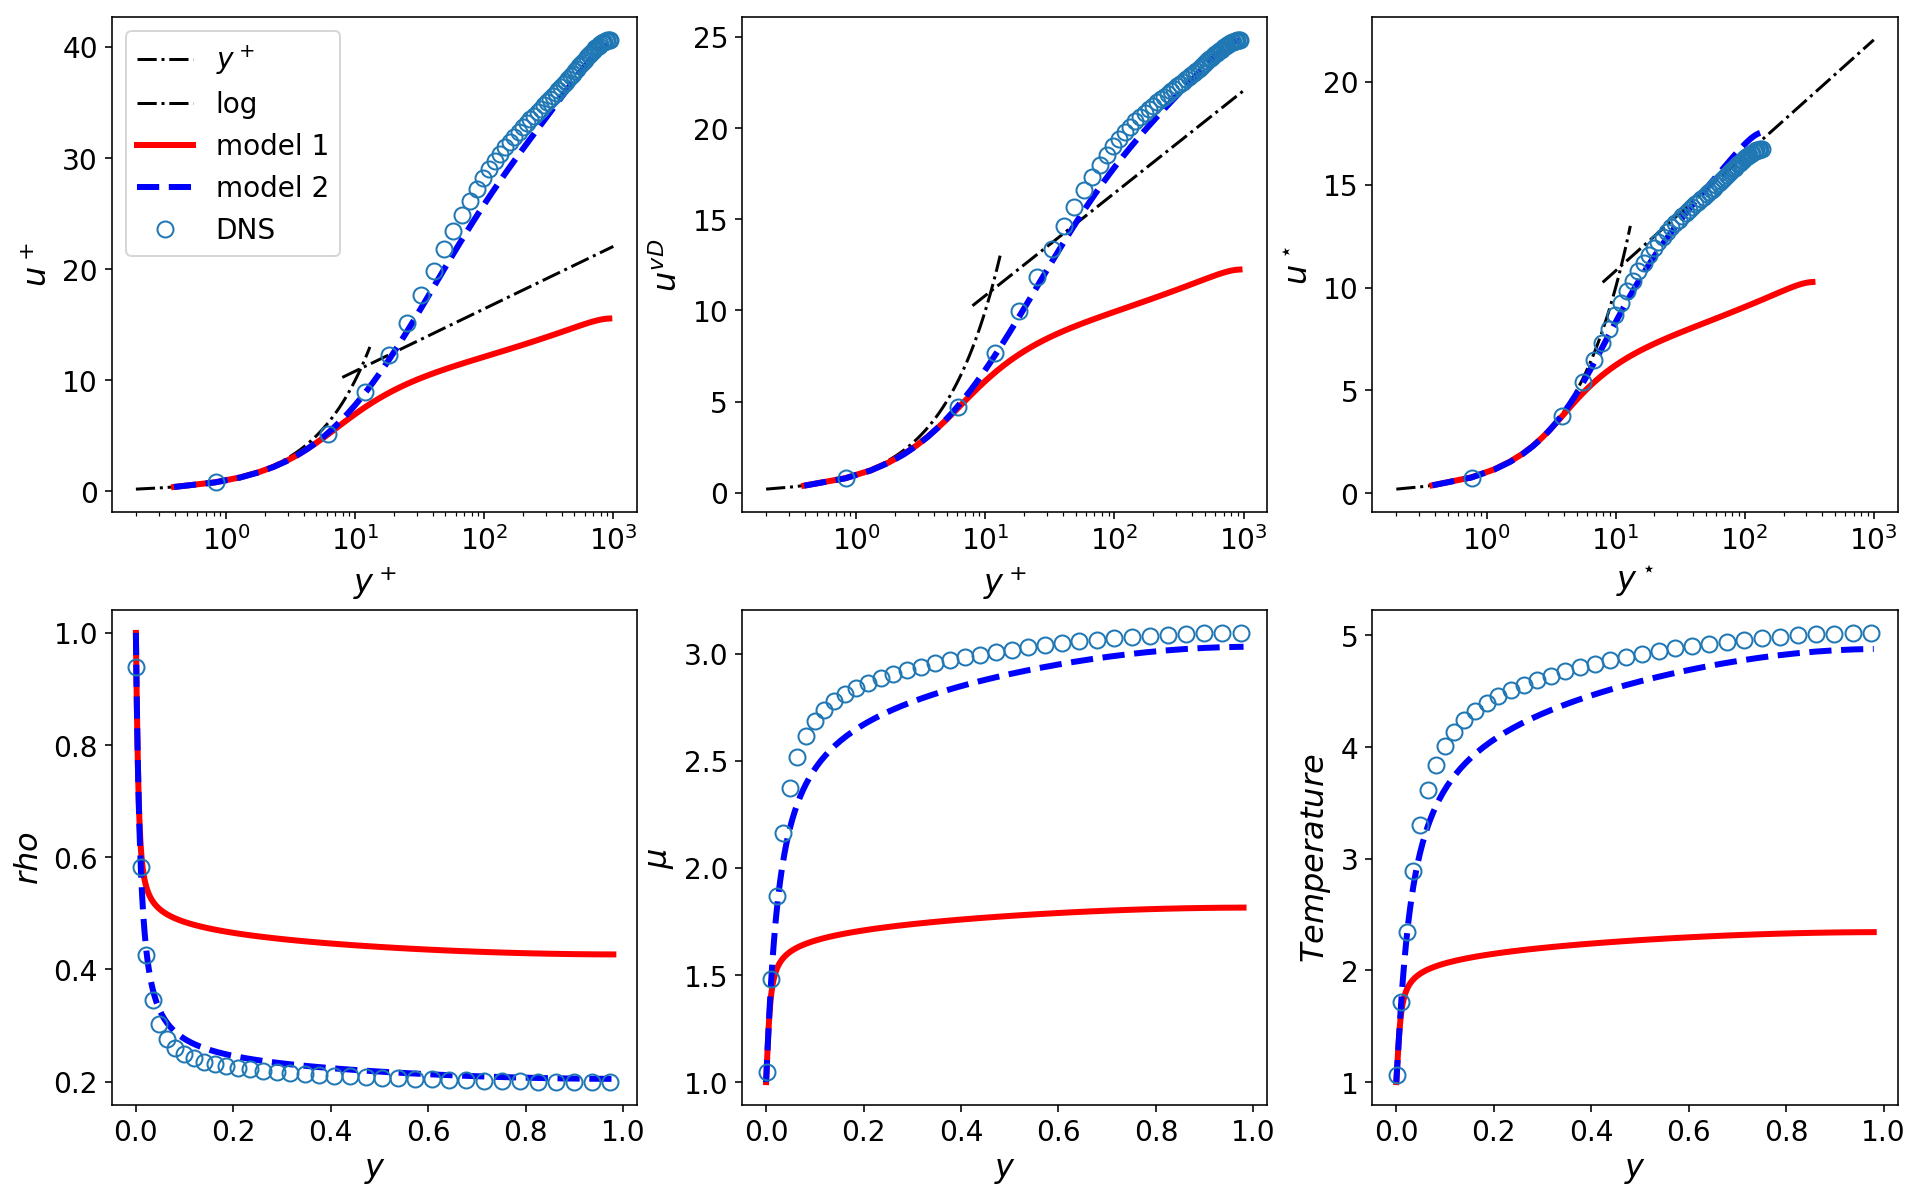

In [115]:
n = mesh.nPoints

# model 1
ypl1,uvd1 = velTransVD(u1,r1,ReTau,mesh)      # note, u is already u+ due to normalization
yst1,ust1 = velTransSLS(u1,r1,mu1,ReTau,mesh)

# model 2
ypl2,uvd2 = velTransVD(u2,r2,ReTau,mesh)      # note, u is already u+ due to normalization
yst2,ust2 = velTransSLS(u2,r2,mu2,ReTau,mesh)


ax = plt.subplot(2,3, 1)
# analytic results for viscous sub-layer
ypLam = np.linspace(0.2,13,100); 
ax.semilogx(ypLam,ypLam,'k-.')
    
# semi-empirical result for log-layer
ypTurb = np.linspace(0.9,3,20); 
upTurb = 1/0.41*np.log(np.power(10, ypTurb))+5.2
ax.semilogx(np.power(10, ypTurb), upTurb,'k-.')

# model solution
line1 = ax.semilogx(ypl1[1:n//2],u1[1:n//2], 'r-',linewidth=3)
line2 = ax.semilogx(ypl2[1:n//2],u2[1:n//2], 'b--',linewidth=3)
line3 = ax.plot(DNS[::3,1],DNS[::3,8],'o',fillstyle='none',linewidth=4, markersize=8)
plt.xlabel('$y^+$', fontsize=16); plt.ylabel('$u^+$', fontsize=16);
plt.legend(('$y^+$','log','model 1','model 2', 'DNS'))

plt.subplot(2,3, 2)
plt.semilogx(ypLam,ypLam,'k-.'); plt.semilogx(np.power(10, ypTurb), upTurb,'k-.')
plt.semilogx(ypl1[1:n//2],uvd1[1:n//2],'r-',linewidth=3)
plt.semilogx(ypl2[1:n//2],uvd2[1:n//2],'b--',linewidth=3)
plt.plot(DNS[::3,1],DNS[::3,10],'o',fillstyle='none',linewidth=4, markersize=8)
plt.xlabel('$y^+$', fontsize=16); plt.ylabel('$u^{vD}$', fontsize=16);

plt.subplot(2,3, 3)
plt.semilogx(ypLam,ypLam,'k-.'); plt.semilogx(np.power(10, ypTurb), upTurb,'k-.')
plt.semilogx(yst1[1:n//2],ust1[1:n//2],'r-',linewidth=3)
plt.semilogx(yst2[1:n//2],ust2[1:n//2],'b--',linewidth=3)
plt.plot(DNS[::3,2],DNS[::3,11],'o',fillstyle='none',linewidth=4, markersize=8)
plt.xlabel('$y^\star$', fontsize=16); plt.ylabel('$u^\star$', fontsize=16);

plt.subplot(2,3, 4)
plt.plot(mesh.y[0:n//2],r1[0:n//2],'r-',linewidth=3)
plt.plot(mesh.y[0:n//2],r2[0:n//2],'b--',linewidth=3)
plt.plot(DNS[::5,0],DNS[::5,5],'o',fillstyle='none',linewidth=4, markersize=8)
plt.xlabel('$y$', fontsize=16); plt.ylabel('$rho$', fontsize=16);

plt.subplot(2,3, 5)
plt.plot(mesh.y[0:n//2],mu1[0:n//2]/mu[0],'r-',linewidth=3)
plt.plot(mesh.y[0:n//2],mu2[0:n//2]/mu2[0],'b--',linewidth=3)
plt.plot(DNS[::5,0],DNS[::5,6]/mu[0],'o',fillstyle='none',linewidth=4, markersize=8)
plt.xlabel('$y$', fontsize=16); plt.ylabel('$\mu$', fontsize=16);

plt.subplot(2,3, 6)
plt.plot(mesh.y[0:n//2],T1[0:n//2],'r-',linewidth=3)
plt.plot(mesh.y[0:n//2],T2[0:n//2],'b--',linewidth=3)
plt.plot(DNS[::5,0],DNS[::5,14],'o',fillstyle='none',linewidth=4, markersize=8)
plt.xlabel('$y$', fontsize=16); plt.ylabel('$Temperature$', fontsize=16);
